In [20]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/results/results.csv")

In [22]:

df

,Unnamed: 0,Patient_id,Image_path,Mask_path,Image_mask_path,Class
0,0,ID00358637202295388077032,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,1
1,1,ID00358637202295388077032,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,1
2,2,ID00358637202295388077032,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,1
3,3,ID00358637202295388077032,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,1
4,4,ID00358637202295388077032,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,1
...,...,...,...,...,...,...
5290,5290,ID00168637202237852027833,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,5
5291,5291,ID00168637202237852027833,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,5
5292,5292,ID00168637202237852027833,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,5
5293,5293,ID00168637202237852027833,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,/content/drive/MyDrive/Colab Notebooks/Pulmona...,5


In [23]:
import tensorflow
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

df.Class = df.Class.astype(str)
datagen = ImageDataGenerator()

target_size=(128,128)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Mask_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='sparse',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Mask_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='sparse',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)


Found 4236 validated image filenames belonging to 5 classes.
Found 1059 validated image filenames belonging to 5 classes.


In [24]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import tensorflow as tf
base_model=InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

In [25]:
from keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(train_data_generator,
                    steps_per_epoch=4236   //64,
                    epochs = 20,
                    validation_data=val_data_generator,
                    validation_steps= 1059 // 64,
                    callbacks = [callback])

Epoch 1/20
66/66 [==============================] - 1776s 26s/step - loss: 0.8949 - accuracy: 0.6330 - val_loss: 19.0540 - val_accuracy: 0.2676
Epoch 2/20
66/66 [==============================] - 1514s 23s/step - loss: 0.5502 - accuracy: 0.7768 - val_loss: 3.3144 - val_accuracy: 0.3154
Epoch 3/20
66/66 [==============================] - 1534s 23s/step - loss: 0.4543 - accuracy: 0.8116 - val_loss: 0.9443 - val_accuracy: 0.6953
Epoch 4/20
66/66 [==============================] - 1536s 23s/step - loss: 0.4187 - accuracy: 0.8284 - val_loss: 0.6283 - val_accuracy: 0.7754
Epoch 5/20
66/66 [==============================] - 1518s 23s/step - loss: 0.3612 - accuracy: 0.8454 - val_loss: 0.4502 - val_accuracy: 0.8271
Epoch 6/20
66/66 [==============================] - 1545s 23s/step - loss: 0.3564 - accuracy: 0.8518 - val_loss: 0.4120 - val_accuracy: 0.8408
Epoch 7/20
66/66 [==============================] - 1532s 23s/step - loss: 0.3417 - accuracy: 0.8526 - val_loss: 0.5084 - val_accuracy: 0.757

In [28]:
import numpy as np
y_pred = model.predict_generator(val_data_generator, 1059 // 64+1)
Y_pred = np.argmax(y_pred, axis=1)


<ipython-input-28-f6fcdf5d96bf>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(val_data_generator, 1059 // 64+1)


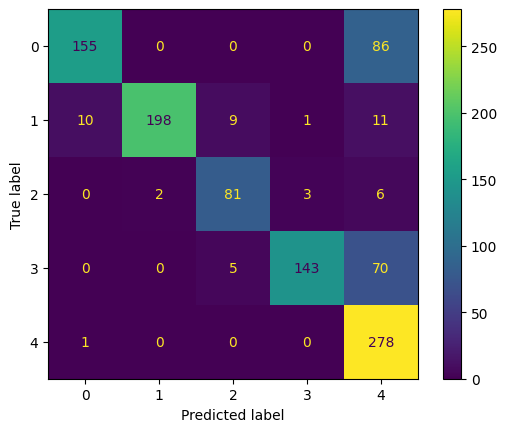

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = confusion_matrix(val_data_generator.classes, Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [30]:
print(classification_report(val_data_generator.classes, Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.64      0.76       241
           1       0.99      0.86      0.92       229
           2       0.85      0.88      0.87        92
           3       0.97      0.66      0.78       218
           4       0.62      1.00      0.76       279

    accuracy                           0.81      1059
   macro avg       0.87      0.81      0.82      1059
weighted avg       0.86      0.81      0.81      1059



In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(val_data_generator.classes, Y_pred)

0.8073654390934845